# Demo para Estudiar los Datos Disponibles sobre Naves Imperiales de Star Wars


In [ ]:
#@title Librerías a usar
import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import csv

from sklearn import tree
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

print("Librerías cargadas")

Librerías cargadas


In [ ]:
#@title Funciones Auxiliares

# variables auxiliares
atributo_clase = ""

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# devuelve listas de columnas numéricas y no numéricas
def devolNombreColumnas(ndf):
  colValues = []
  colNoValues = []
  for col in ndf.columns:
    if ndf[col].dtypes in ("object", "bool"):
      colNoValues.append( col )
    else:
      colValues.append( col )
  return colValues, colNoValues

# función auxiliar para separar datos de entrada y de salida
def separarDatosXY(ndf, atributo_clase="", xSoloNros=True):
  # hace una copia auxiliar del data frame
  cdf = ndf.copy()
  # saca el atributo clase (OPCIONAL)
  if atributo_clase == "":
    Y = []
  else:
    # datos atributo clase
    Y = np.array( cdf.pop(atributo_clase).fillna("-NAN-") )
  if xSoloNros:
    # se queda sólo con los atributos numéricos (OPCIONAL)
    for col in cdf.columns:
      if cdf[col].dtypes == "object":
          cdf.pop( col )
  # datos de entrada
  X = np.array(cdf.fillna(0.001))
  return X, Y, np.array(cdf.columns)

def convColsNumericas(ndf, atributos_no_convertir = []):
  # hace una copia auxiliar del data frame
  cdf = ndf.copy()
  # convierte todas las no numéricas a numéricas (OPCIONAL)
  for col in cdf.columns:
    if col not in atributos_no_convertir:
      if cdf[col].dtypes == "object":
        # genera diccionario de valores
        valores = cdf[col].unique()
        diccValores = dict(zip(valores, range(len(valores))))
        # realiza el reemplazo
        cdf[col] = cdf[col].map(lambda s: diccValores.get(s) if s in diccValores else s)
  return cdf

# función auxiliar
def generar_estadisticas_detalladas(orDF, titulo=""):
  # título
  print("\n", titulo, ": ")
  # obtiene las estadísticas generales
  estDF = orDF.describe().transpose()
  #  genera y formatea las estadísticas
  if "min" in estDF and "max" in estDF:
    rangoValores = "[ " + estDF["min"].apply('{:.2f}'.format) + " ; " + estDF["max"].apply('{:.2f}'.format) + " ]"
  else:
    rangoValores = estDF["unique"].fillna(0.0).apply('{:.0f}'.format)
  rangoValores.name = "Rango Valores"
  # para campos no numéricos muestra las cantidades por valor
  for col in orDF.columns:
    if orDF[col].dtypes in ("object", "bool"):
      auxStr = str( orDF[col].value_counts() ).replace("\n", " ; ")
      if (auxStr.index("Name")-3) > 0:
        # saca lo del final porque no sirve
        auxStr = auxStr[:auxStr.index("Name")-3]
      rangoValores[col] = "{ " + auxStr + " }"
  if "mean" in estDF and "std" in estDF:
    promValores = estDF["mean"].fillna(0.0).apply('{:.3f}'.format) + " ± " + estDF["std"].fillna(0.0).apply('{:.3f}'.format)
  else:
    promValores = estDF["count"].apply('{:.0f}'.format)
  promValores.name = "Promedio ± Desvío"
  # obtiene valores "ceros" y nulos
  zero_val = (orDF == 0.00).astype(int).sum(axis=0)
  zero_val.name = "¿Valores Ceros?"
  mis_val = orDF.isnull().sum()
  mis_val.name = "¿Valores Nulos?"
  # prepara la nueva tabla para mostrar
  nTable = pd.concat([orDF.dtypes, rangoValores, promValores, zero_val, mis_val], axis=1)
  nTable = nTable.rename( columns = {0: 'Tipo Valor',  1: 'Rango Valores', 2: 'Promedio ± Desvío', 3: '¿Valores Ceros?', 4: '¿Valores Nulos?' } )
  # muestra la nueva tabla
  pd.set_option('max_colwidth', None)
  display(nTable.fillna("-"))
  print("Tiene " + str(orDF.shape[1]) + " atributos y " + str(orDF.shape[0]) + " ejemplos.")
  print("\n")
  return

print("Funciones auxiliares definidas.")

Funciones auxiliares definidas.


# Carga de los Datos:

In [ ]:
#@title Acceder Google Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

#@markdown ### Directorio  en Google Drive:
path = '/content/gdrive/MyDrive/IA/demoStarWars/datos/'  #@param {type:"string"}



Mounted at /content/gdrive


In [ ]:

#@title Cargar datos


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'naves.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Y, X, nombre_clases, atributos_entrada, ClassAttributeName, atributo_clase

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )

  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return

  # guarda para usar luego
  atributos_entrada = att_entrada
  ClassAttributeName = attClase
  atributo_clase = attClase

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")
ndf = df

print("\n> Cabecera: ")
print(df.head())

# inicializa valores
X = None
Y = None
atributos_entrada = []
ClassAttributeName = ""
atributo_clase = ""

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  naves.csv  cargado

> Cabecera: 
   Manufacturer  Length  Crew  Cargo Capacity  Consumables  Speed   Hull  \
0          14.0     6.3   1.0            65.0     0.066667  100.0    9.0   
1          20.0     7.0   1.0            65.0     0.066667  100.0   10.0   
2          24.0   100.0  45.0        500000.0     5.000000   70.0  257.0   
3          18.0     6.3   1.0            65.0     0.066667  100.0    9.0   
4          18.0     6.3   1.0            65.0     0.066667  110.0    9.0   

   Troops  Hyperdrive Multiplier  Hyperdrive Backup  Shields  \
0     0.0                   -1.0               -1.0     -1.0   
1     0.0                   -1.0               -1.0     -1.0   
2    60.0                    1.0               15.0    622.0   
3     0.0                   -1.0               -1.0     -1.0   
4     0.0                   -1.0               -1.0     20.0   

   Special Features  Onboard Craft  BLASTER CANNONS  LASER CANNON TURRETS  \
0          0.037319       0.02

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo Ship Type como de entrada dado que es clase.


In [ ]:
#@title Mostrar Estadísticas Generales de Datos Cargados { run: "auto" }

# muestra las estadísticas
generar_estadisticas_detalladas(ndf, "> Estadísticas de los datos cargados")



 > Estadísticas de los datos cargados : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
Manufacturer,float64,[ 0.00 ; 29.00 ],14.626 ± 7.205,1,0
Length,float64,[ 2.10 ; 16000.00 ],481.423 ± 2123.802,0,0
Crew,float64,[ 0.00 ; 712645.00 ],14605.710 ± 90254.128,2,0
Cargo Capacity,float64,[ -1.00 ; 600000000.00 ],15213112.766 ± 75767701.080,0,0
Consumables,float64,[ 0.03 ; 120.00 ],8.328 ± 19.252,0,0
Speed,float64,[ 4.00 ; 155.00 ],69.159 ± 38.796,0,0
Hull,float64,[ 5.00 ; 77710.00 ],1473.692 ± 8888.793,0,0
Troops,float64,[ 0.00 ; 150000.00 ],3293.393 ± 19163.088,50,0
Hyperdrive Multiplier,float64,[ -1.00 ; 15.00 ],0.899 ± 2.004,0,0
Hyperdrive Backup,float64,[ -1.00 ; 20.00 ],4.972 ± 7.145,0,0


Tiene 75 atributos y 107 ejemplos.




In [ ]:
#@title Controlar ejemplos inconsistentes  { run: "auto" }
#@markdown Nota: los ejemplos inconsistentes son los que tienen mismo valores de entrada pero distintos valores de salida

ejIncs = None

# Botones de acciones
def mostrarEstIncs(b):
  with output:
    clear_output()
    global ejIncs, ndf
    if ejIncs is not None and len(ndf[ejIncs])>0:
      generar_estadisticas_detalladas(ndf[ejIncs], "Estadística de ejemplos inconsistentes")
    else:
      print("\n No hay ejemplos inconsistentes para mostrar!")

def eliminarIncs(b):
  with output:
    clear_output()
    global ejIncs, ndf
    if ejIncs is not None and len(ndf[ejIncs])>0:
      ndf = ndf[~ejIncs] ## borra todos los inconsistentes!!!
      print("\n Ejemplos inconsistentes eliminados.")
    else:
      print("\n No hay ejemplos inconsistentes para eliminar!")


layoutButton = widgets.Layout(width='auto', height='40px') #set width and height
buttonMeInc = widgets.Button(description="Mostrar Estadísticas Inconsistentes",
                          display='flex',
                          flex_flow='column',
                          align_items='stretch',
                          layout = layoutButton)
buttonMeInc.on_click(mostrarEstIncs)
buttonMeInc = widgets.Button(description="Eliminar Inconsistentes",
                          display='flex',
                          flex_flow='column',
                          align_items='stretch',
                          layout = layoutButton)
buttonMeInc.on_click(eliminarIncs)
outputInc = widgets.Output()

if len(ndf)>0:
  print("\n> Resultados de controlar ejemplos inconsistentes: ")

  # determina columnas de entrada solamente
  arCols = list(ndf.columns)
  arCols.remove(atributo_clase)

  # detecta los ejemplos inconsistentes
  ###  https://stackoverflow.com/questions/61909261/how-can-we-detect-inconsistency-in-pandas-dataframe
  mask1 = ndf.duplicated(arCols, keep=False)
  mask2 = ~ndf.duplicated(arCols + [atributo_clase], keep=False)
  ejIncs = (mask1 & mask2)

  # calcula las cantidades
  cantInc = len(ndf[ejIncs])
  canNotInc = len(ndf[~ejIncs])

  # muestra resultados
  if cantInc > 0:
    # muestra datos ordenadaso
    print("\n")
    display(ndf[ejIncs].sort_values(by=list(arCols)))
  print("- Cantidad de ejemplos inconsistentes = ", cantInc, "(", round((cantInc/(cantInc+canNotInc))*100,1), "%)")
  print("+ Cantidad de ejemplos correctos = ", canNotInc, "(", round((canNotInc/(cantInc+canNotInc))*100,1), "%)")
  print("= Cantidad total de ejemplos = ", (cantInc+canNotInc))

  if cantInc > 0:
    # si hay duplicados
    print("\n> Posibles acciones a realizar:")
    display(buttonMeInc, buttonMeInc, outputInc)




> Resultados de controlar ejemplos inconsistentes: 
- Cantidad de ejemplos inconsistentes =  0 ( 0.0 %)
+ Cantidad de ejemplos correctos =  107 ( 100.0 %)
= Cantidad total de ejemplos =  107


In [ ]:
#@title Controlar ejemplos duplicados (OPCIONAL) { run: "auto" }
detectar_ejemplos_duplicados = True #@param {type:"boolean"}

if detectar_ejemplos_duplicados:

  # carga las columnas numéricas y no numéricas
  todasCols = list(ndf.columns)

  # combo selección de columnas
  selColumnas = widgets.SelectMultiple(
      options=todasCols,
      value=list(todasCols),
      description='Atributos seleccionados:',
      rows=len(todasCols),
      layout=Layout(display="flex")
  )

  ui = widgets.HBox([selColumnas])

  dups = None

  # Botones de acciones
  def mostrarDups(b):
    with output:
      clear_output()
      global dups, ndf
      if dups is not None and len(ndf[dups])>0:
        display( ndf[dups].sort_values(by=list(ndf.columns)) )
      else:
        print("\n No hay duplicados para mostrar!")
  def mostrarEstDups(b):
    with output:
      clear_output()
      global dups, ndf
      if dups is not None and len(ndf[dups])>0:
        generar_estadisticas_detalladas(ndf[dups], "Estadística de ejemplos duplicados")
      else:
        print("\n No hay duplicados para mostrar!")
  def eliminarDups(b):
    with output:
      clear_output()
      global dups, ndf
      if dups is not None and len(ndf[dups])>0:
        ndf = ndf[~dups] # deja una copia y borra el resto
        cambiaSeleccionDup(selColumnas.value)
        print("\n Ejemplos duplicados eliminados.")
      else:
        print("\n No hay duplicados para eliminar!")


  layoutButton = widgets.Layout(width='auto', height='40px') #set width and height
  buttonMD = widgets.Button(description="Mostrar Datos Duplicados",
                            display='flex',
                            flex_flow='column',
                            align_items='stretch',
                            layout = layoutButton)
  buttonMD.on_click(mostrarDups)
  buttonMeD = widgets.Button(description="Mostrar Estadísticas Duplicados",
                            display='flex',
                            flex_flow='column',
                            align_items='stretch',
                            layout = layoutButton)
  buttonMeD.on_click(mostrarEstDups)
  buttonED = widgets.Button(description="Eliminar Duplicados",
                            display='flex',
                            flex_flow='column',
                            align_items='stretch',
                            layout = layoutButton)
  buttonED.on_click(eliminarDups)
  output = widgets.Output()


  def cambiaSeleccionDup(cols):
    global dups
    # convierte la selección a un array
    arCols = np.array(cols)
    print("\n> Resultados de controlar ejemplos duplicados con atributos seleccionados: ")

    # detecta los ejemplos duplicados
    # (marca todos con 'True')
    dups = ndf.duplicated(subset=arCols, keep="first")
    # calcula las cantidades
    cantDup = len(ndf[dups])
    cantNoDup = len(ndf[~dups])

    # muestra resultados
    print("   - Cantidad de ejemplos con valores duplicados = ", cantDup, "(", round((cantDup/(cantDup+cantNoDup))*100,1), "%)")
    print("   + Cantidad de ejemplos con valores diferentes = ", cantNoDup, "(", round((cantNoDup/(cantDup+cantNoDup))*100,1), "%)")
    print("   = Cantidad total de ejemplos = ", (cantDup+cantNoDup))

    if cantDup > 0:
      # si hay duplicados
      print("\n> Posibles acciones a realizar:")
      display(buttonMD, buttonMeD, buttonED, output)

  out = widgets.interactive_output(cambiaSeleccionDup, {'cols': selColumnas})
  display(ui, out)

else:
  print("No se controlan datos duplicados.")


Output()

# Gráficos Estadísticos:

In [ ]:
#@title Generar gráfico de Quartile o BoxPlot { run: "auto" }

def genGraph_BoxPlot(ndf, titulo):
  fig = plt.figure(figsize=(15,8))
  legValues = []
  colValues = []
  for col in ndf.columns:
    if ndf[col].dtypes != "object":
      legValues.append( col )
      colValues.append( ndf[col].fillna(0.001) )
  if len(colValues)>0:
    ax = fig.add_axes( [0, 0, 0.8, 0.8] )
    ax.boxplot( colValues )
    ax.set_xticklabels( legValues )
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.show()

# carga las columnas numéricas y no numéricas
colValues, _ = devolNombreColumnas(ndf)

selColumnas = widgets.SelectMultiple(
    options=colValues,
    value=list(colValues),
    description='Atributos a mostrar:')

# agrega CB para determinar si muestra por clase
generaXclase = widgets.Checkbox(
    value=False,
    description='Generar gráfico por Valor Clase',
    disabled=False,
    indent=False
)

ui = widgets.VBox([selColumnas, generaXclase])

def cambiaSeleccion(cols, grafico_por_valor_clase):
  # convierte la selección a un array
  arCols = np.array(cols)
  # genera los gráficos
  tit = "Gráfico Estadístico de Quartile / BoxPlot"
  if grafico_por_valor_clase:
    for val in  ndf[atributo_clase].unique():
      auxDF = ndf[ ndf[atributo_clase] == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1)
      genGraph_BoxPlot(auxDF[arCols], tit + " para valor de clase '" + str(val) + "'" )
  else:
    genGraph_BoxPlot(ndf[arCols], tit)


out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas, 'grafico_por_valor_clase': generaXclase})
display(ui, out)



Output()

In [ ]:
#@title Generar gráfico de Deviation  { run: "auto" }

def genGraph_Deviation(oriDF, titulo, porClase):
  fig = plt.figure(figsize=(15,8))

  listDF = []
  legValues = []
  if porClase:
    # genera sub-DF por valor de clase
    for val in oriDF[atributo_clase].unique():
      auxDF = oriDF[ oriDF[atributo_clase] == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1)
      listDF.append( auxDF.fillna(0.001) )
      legValues.append( atributo_clase + " " + str(val))
  else:
    # usa todos los datos como sub-DF
    listDF.append( oriDF )

  # genera línea por sub-DF
  for ndf in listDF:
    xLabel = []
    meanValues = []
    stdValues = []
    for col in ndf.columns:
      if ndf[col].dtypes != "object":
        xLabel.append( col )
        meanValues.append( ndf[col].mean() )
        stdValues.append( ndf[col].std() )
    plt.errorbar(xLabel, meanValues, yerr=stdValues)

  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  if len(legValues) > 0:
    plt.legend(legValues, loc='best')
  plt.show()


# carga las columnas numéricas y no numéricas
colValues, _ = devolNombreColumnas(ndf)

selColumnas = widgets.SelectMultiple(
    options=colValues,
    value=list(colValues),
    description='Atributos a mostrar:')

# agrega CB para determinar si muestra por clase
generaXclase = widgets.Checkbox(
    value=False,
    description='Generar gráfico por Valor Clase',
    disabled=False,
    indent=False
)

ui = widgets.VBox([selColumnas, generaXclase])

def cambiaSeleccion(cols, grafico_por_valor_clase):
  # convierte la selección a un array
  if grafico_por_valor_clase:
    # agrega el atributo clase para mostrar
    cols = list(cols)
    cols.append(atributo_clase)
  arCols = np.array(cols)
  # genera  gráfico
  tit = "Gráfico Estadístico de Deviation"
  genGraph_Deviation(ndf[arCols], tit, grafico_por_valor_clase)


out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas, 'grafico_por_valor_clase': generaXclase})
display(ui, out)

Output()

In [ ]:
#@title Generar gráfico de Histogram { run: "auto" }

cantidad_bins = 10 #@param {type:"integer"}

if cantidad_bins <= 1:
  cantidad_bins = 1

def genGraph_Histogram(ndf, titulo):
  fig = plt.figure(figsize=(15,8))
  legValues = []
  for col in ndf.columns:
    if ndf[col].dtypes != "object":
      plt.hist( ndf[col].fillna(0.001), bins = cantidad_bins )
      legValues.append( col )
  plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.2)
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.xlabel('Valor')
  plt.ylabel('Frencuencia')
  plt.legend(legValues, loc='best')
  plt.show()

# carga las columnas numéricas y no numéricas
colValues, _ = devolNombreColumnas(ndf)

selColumnas = widgets.SelectMultiple(
    options=colValues,
    value=list(colValues),
    description='Atributos a mostrar:')

# agrega CB para determinar si muestra por clase
generaXclase = widgets.Checkbox(
    value=False,
    description='Generar gráfico por Valor Clase',
    disabled=False,
    indent=False
)

ui = widgets.VBox([selColumnas, generaXclase])

def cambiaSeleccion(cols, grafico_por_valor_clase):
  # convierte la selección a un array
  arCols = np.array(cols)
  # genera los gráficos
  tit = "Gráfico Estadístico de Histograma"
  if grafico_por_valor_clase:
    for val in  ndf[atributo_clase].fillna("-NAN-").unique():
      auxDF = ndf[ ndf[atributo_clase] == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1)
      genGraph_Histogram(auxDF[arCols], tit + " para valor de clase '" + str(val) + "'" )
  else:
    genGraph_Histogram(ndf[arCols], tit)



out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas, 'grafico_por_valor_clase': generaXclase})
display(ui, out)




Output()

In [ ]:
#@title Generar gráfico de Series { run: "auto" }

def genGraph_Series(ndf, titulo, incluir_valores_discretos):
  fig = plt.figure(figsize=(15,8))
  legValues = []
  for col in ndf.columns:
    if incluir_valores_discretos or ndf[col].dtypes != "object":
      if ndf[col].dtypes == "object":
        plt.plot( ndf[col].fillna("-NAN-") )
      else:
        plt.plot( ndf[col].fillna(0.001) )
      legValues.append( col )
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.ylabel('Valor')
  plt.xlabel('# Fila')
  plt.legend(legValues, loc='best')
  plt.show()


# carga las columnas numéricas y no numéricas
todasCols = list(ndf.columns)

selColumnas = widgets.SelectMultiple(
    options=todasCols,
    value=list(todasCols),
    description='Atributos a mostrar:')

# agrega CB para determinar si muestra por clase
generaXclase = widgets.Checkbox(
    value=False,
    description='Generar gráfico por Valor Clase',
    disabled=False,
    indent=False
)

ui = widgets.VBox([selColumnas, generaXclase])

def cambiaSeleccion(cols, grafico_por_valor_clase, incluye_discretos=True):
  # convierte la selección a un array
  arCols = np.array(cols)
  # genera los gráficos
  tit = "Gráfico Estadístico de Series"
  if grafico_por_valor_clase:
    for val in  ndf[atributo_clase].unique():
      auxDF = ndf[ ndf[atributo_clase] == val]
      auxDF = auxDF.drop(labels=atributo_clase, axis=1)
      genGraph_Series(auxDF[arCols], tit + " para valor de clase '" + str(val) + "'", incluye_discretos)
  else:
    genGraph_Series(ndf[arCols], tit, incluye_discretos)

out = widgets.interactive_output(cambiaSeleccion, {'cols': selColumnas, 'grafico_por_valor_clase': generaXclase})
display(ui, out)


Output()

In [ ]:
#@title Generar gráfico de Scatter

# carga las columnas numéricas y no numéricas
colValues, colNoValues = devolNombreColumnas(ndf)
colNoValues.insert(0, "-")

# agrega los combos
comboColX = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Columna X:',
    disabled=False,
)
if len(colValues)>1:
  valYsel = colValues[1]
else:
  valYsel = colValues[0]

comboColY = widgets.Dropdown(
    options=colValues,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

comboColZ = widgets.Dropdown(
    options=colNoValues,
    value=colNoValues[0],
    description='Columna Z:',
    disabled=False,
)

ui = widgets.HBox([comboColX, comboColY, comboColZ])

def genGraph_Scatter(ndf, colx, coly, colz, titulo):
  if colx not in ndf or coly not in ndf or (colz!="" and colz not in ndf):
    if colx not in ndf:
      print("Nombre de columna X '" + colx + "' no existente!!")
    elif coly not in ndf:
      print("Nombre de columna Y '" + coly + "' no existente!!")
    elif (colz!="" and colz not in ndf):
      print("Nombre de columna Z '" + colz + "' no existente!!")
    return
  else:
    fig = plt.figure(figsize=(15,8))
    if colz == "":
      # gráfico general
      plt.scatter(ndf[colx], ndf[coly])
    else:
      # gráfico marcando colores por valor de colz
      legValues = []
      for val in  ndf[colz].unique():
        auxDF = ndf[ ndf[colz] == val]
        auxDF = auxDF.drop(labels=colz, axis=1)
        plt.scatter(auxDF[colx], auxDF[coly])
        legValues.append(val)
      plt.legend(legValues, loc='best')
    plt.xlabel(colx)
    plt.ylabel(coly)
    plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
    plt.grid(color='lightgrey', which='major', axis='x', linestyle='solid', linewidth=0.3)
    plt.show()

def cambiaSeleccion(x, y, z):
  # llama a la función
  # para generar el gráfico con las columnas seleccionadas
  tit = "Gráfico Estadístico de Scatter"
  if z == "-":
    z = ""
  genGraph_Scatter(ndf, x, y, z, tit)

out = widgets.interactive_output(cambiaSeleccion, {'x': comboColX, 'y': comboColY, 'z': comboColZ})
display(ui, out)

Output()

Matriz de Correlación:



,Manufacturer,Consumables,Speed,Onboard Craft,Ship Type
Manufacturer,1.000,-0.263,0.306,-0.241,0.551
Consumables,-0.263,1.000,-0.568,0.727,-0.530
Speed,0.306,-0.568,1.000,-0.698,0.712
Onboard Craft,-0.241,0.727,-0.698,1.000,-0.626
Ship Type,0.551,-0.530,0.712,-0.626,1.000


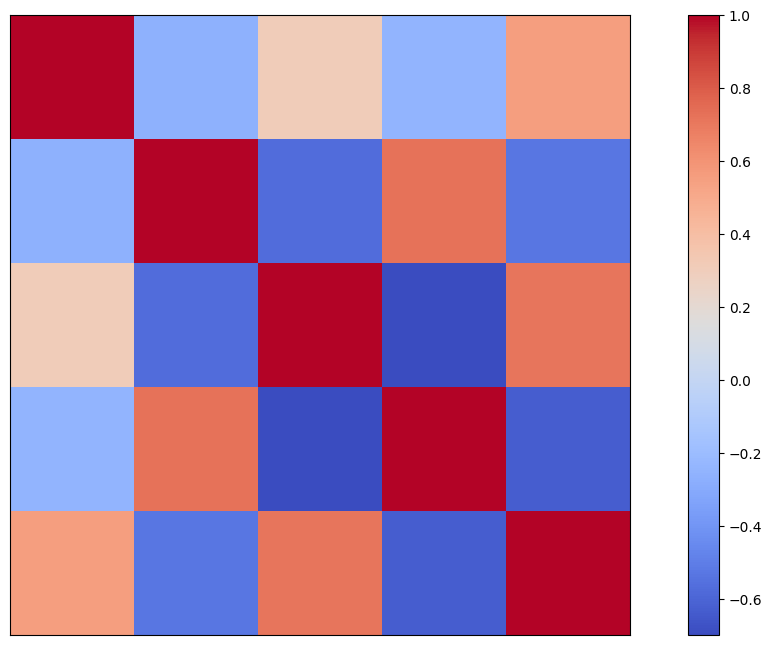

In [ ]:
#@title Generar Matriz de Correlación { run: "auto" }

filtrar_significativos_clase = True #@param {type:"boolean"}

if atributo_clase != "":
  ndfCorr = ndf.copy()
  if ndfCorr[atributo_clase].dtype == "object":
    # transforma a valores numéricos para que aparezca en la correlación
    ClaseValores = list(ndfCorr[atributo_clase])
    CLASES = list(set(ClaseValores))
    CLASES.sort()
    # cambia valores para que sean enteros
    ClaseValoresNro = [ CLASES.index(y) for y in ClaseValores]
    ndfCorr[atributo_clase] = ClaseValoresNro

  # genera correlación con valores de clase
  corr = ndfCorr.corr()
  if filtrar_significativos_clase:
    # filtra matriz para que muestre solo los que  el valor de correlación es mayor a +/-0.5
    corr = corr[abs(corr[atributo_clase]) >= 0.5]
    corr = corr[corr.index.values.tolist()]
else:
    # genera correlación directa
    corr = ndf.corr()

# muestra la matriz generada
print('Matriz de Correlación:\n')
display( corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=3) )
print("\n")

# muestra la figura
fig = plt.figure(figsize=(15,8))
plt.matshow(corr,  fignum=fig.number, cmap='coolwarm')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.xticks(())
plt.yticks(())
#plt.title('Matriz de Correlación')
plt.show()

#Resultados de aplicar Algoritmos de Minería de Datos:

In [ ]:
#@title Aplicar Descubrimiento de Reglas ( Decision Tree ) { run: "auto" }

# carga las columnas no numéricas
colValues, colNoValues = devolNombreColumnas(ndf)


if len(colNoValues)<1:
  raise ValueError("No se encuentra ningún atributo no numérico para utilizar como objetivo!!!")

selColumnas = widgets.SelectMultiple(
    options=colValues,
    value=list(colValues),
    description='Atr.Entrada:')

comboClase = widgets.Dropdown(
    options=colNoValues,
    value=(atributo_clase if (atributo_clase!="" and atributo_clase in colNoValues) else colNoValues[0]),
    description='Atr.Clase:',
    disabled=False,
)

ui = widgets.HBox([selColumnas, comboClase])

def cambiaSeleccion(atributos_entrada, atributo_clase_tree):
    # convierte la selección a un array
    # agrega el atributo clase para mostrar
    cols = list(atributos_entrada)
    cols.append(atributo_clase_tree)
    arCols = np.array(cols)

    # obtiene los datos para entrenar el algoritmo
    X, Y, xColName = separarDatosXY(ndf[arCols], atributo_clase_tree, xSoloNros=True)

    # determina nombre de atributos y valores clase
    cols = xColName
    classvalues = np.unique(Y)

    # genera el árbol y lo muestra
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X, Y)

    ## muestra el árbol
    plt.figure(figsize=(15,8))
    tree.plot_tree(clf,
                  feature_names=cols,
                  class_names=classvalues,
                  impurity=False,
                  rounded=True,
                  filled=True,
                  fontsize=11)
    plt.show()

out = widgets.interactive_output(cambiaSeleccion, {'atributos_entrada': selColumnas, 'atributo_clase_tree': comboClase})
display(ui, out)

Output()

In [ ]:
#@title Aplicar Ponderación ( Naive Bayes )

# carga las columnas numéricas y no numéricas
colValues, colNoValues = devolNombreColumnas(ndf)

if len(colNoValues)<1:
  raise ValueError("No se encuentra ningún atributo no numérico para utilizar como objetivo!!!")

# agrega los combos
comboEnt = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Atr.Entrada:',
    disabled=False,
)

comboClase = widgets.Dropdown(
    options=colNoValues,
    value=colNoValues[0],
    description='Atr.Clase:',
    disabled=False,
)

ui = widgets.HBox([comboEnt, comboClase])

def cambiaSeleccion(atributo_valor_naiveBayes, atributo_clase_naiveBayes):
  # genera el gráfico
  plt.figure(figsize=(15,8))
  legValues = []
  # procesa los valores del atributo clase
  for val in ndf[atributo_clase_naiveBayes].fillna("-NAN-").unique():
      # filtra los datos
      auxDF = ndf[ ndf[atributo_clase_naiveBayes] == val]
      # obtiene valores X, Y de clase y atributo
      Y = np.array(auxDF.pop(atributo_clase_naiveBayes).fillna("-NAN-"))
      X = np.array(auxDF[atributo_valor_naiveBayes].fillna(0.001))
      if len(X)>0 and len(Y)>0:
        legValues.append(val)
        # calcula la densidad
        # instantiate and fit the KDE model
        kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
        kde.fit(X[:, None])
        # score_samples returns the log of the probability density
        x_d = np.linspace(np.min(X), np.max(X), 1000)
        logprob = kde.score_samples(x_d[:, None])
        # genera área del atributo
        plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
        plt.plot(X, np.full_like(X, -0.01), '|k', markeredgewidth=1)
  plt.xlabel("Valores")
  plt.ylabel("Frecuencia")
  plt.legend(legValues, loc='best')
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.show()

out = widgets.interactive_output(cambiaSeleccion, {'atributo_valor_naiveBayes': comboEnt, 'atributo_clase_naiveBayes': comboClase })
display(ui, out)


Output()

In [ ]:
#@title Aplicar Clustering ( K-Means ) { run: "auto" }

#@markdown Cantidad de clústeres a generar:
cantidad_clusters = 3 #@param {type:"integer"}
#@markdown Nombre del atributo clase / objetivo a descartar en el clustering:
atributo_clase_descartar_clustering = "" #@param {type:"string"}

# como mínimo se tienen que generar dos clusters
if cantidad_clusters < 2:
  cantidad_clusters = 2

# controla que exista el atributo_clase
if atributo_clase_descartar_clustering != "" and atributo_clase_descartar_clustering not in ndf:
  raise ValueError("El atributo '" + atributo_clase_descartar_clustering + "' no existe en los datos cargados!!!")

# obtiene los datos para entrenar el algoritmo
X, Y, colValues = separarDatosXY(ndf, atributo_clase_descartar_clustering, xSoloNros=True)
colValues = list(colValues)

# Entrena K-Means
kmeans = KMeans(n_clusters=cantidad_clusters).fit(X)
centroids = kmeans.cluster_centers_
print("Centroides Generados: \n", centroids)
print("\n")

# Determina la salida
labels = kmeans.predict(X)

# agrega los combos
comboColX = widgets.Dropdown(
    options=colValues,
    value=colValues[0],
    description='Columna X:',
    disabled=False,
)
if len(colValues)>1:
  valYsel = colValues[1]
else:
  valYsel = colValues[0]

comboColY = widgets.Dropdown(
    options=colValues,
    value=valYsel,
    description='Columna Y:',
    disabled=False,
)

ui = widgets.HBox([comboColX, comboColY])

def cambiaSeleccion(x, y):
  # llama a la función
  # para generar el gráfico con las columnas seleccionadas
  plt.figure(figsize=(15,8))
  plt.scatter(X[:, colValues.index(x)], X[:, colValues.index(y)], c=labels)
  plt.show()

out = widgets.interactive_output(cambiaSeleccion, {'x': comboColX, 'y': comboColY})
display(ui, out)




Centroides Generados: 
 [[ 1.47980769e+01  1.73194712e+02  1.50664423e+03  3.00922179e+06
   6.14476496e+00  7.05865385e+01  2.58192308e+02  5.80942308e+02
   8.47596154e-01  4.83653846e+00  5.03605769e+02  2.11305790e-01
   1.98457610e-01  4.80769231e-02  1.82692308e-01  3.84615385e-02
   1.50961538e+00  8.17307692e-01  2.48076923e+00  3.46153846e-01
   5.67307692e-01  6.15384615e-01  9.61538462e-02  9.61538462e-03
   1.92307692e-02  7.69230769e-02  1.92307692e-02  9.61538462e-03
   8.65384615e-02  2.88461538e-02  1.92307692e-02  1.73076923e-01
   9.61538462e-03  1.92307692e-02  1.14423077e+00 -1.73472348e-18
   1.78846154e+00  1.92307692e-02  1.92307692e-02  6.73076923e-02
   1.92307692e-01  1.44230769e-01  8.65384615e-02  6.73076923e-02
   1.15384615e-01  1.92307692e-02  7.69230769e-02  9.61538462e-03
   9.61538462e-03  1.25000000e-01  9.61538462e-03  1.95399252e-14
  -3.46944695e-18  3.84615385e-01  7.69230769e-01  1.15384615e-01
   7.69230769e-02  1.92307692e-02  3.84615385e-02  4

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Output()